In [1]:
# import numpy as np
# import cv2
# import os

# from train import M_parser
# from importlib import reload
# import dataset.datahandler as dh
# class DotDict:
#     def __init__(self, **entries):
#         self.__dict__.update(entries)

# # Convert dictionary to a DotDict instance
# cl_args={
#     'cfg_path':'configs/cut.yaml',
#     'data_dir': "Semantic-CARLA/CARLA_Lidar/projected",
#     # 'data_dir_B':"/home/joaquinecc/ailivesim/datasets/semantic_kitti/dataset",
#     'data_dir_B':"/home/joaquinecc/ailivesim/datasets/semantic_kitti/dataset",
#     'batch_size':2,
#     'load':None,
#     'test':False,
#     'ref_dataset_name':None,
#     'norm_label': True,
#     'on_real': False
# }
# cl_args = DotDict(**cl_args)
# opt = M_parser(cl_args.cfg_path, cl_args.data_dir,cl_args.data_dir_B, cl_args.load, cl_args.test, cl_args.batch_size)
# if cl_args.on_real:
#     opt= cl_args.ref_dataset_name
# opt.model.norm_label = cl_args.norm_label

In [37]:
from dataset.datahandler import  KITTIOdometry
import yaml
from util import make_class_from_dict
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from util.lidar import point_cloud_to_xyz_image

In [38]:
root= "Semantic-CARLA/CARLA_Lidar/projected"
split = 'train'
ds_cfg = make_class_from_dict(yaml.safe_load(open(f'configs/dataset_cfg/carla_cfg.yml', 'r')))
modality = ['depth','reflectance','label','rgb']
shape=(64,2048)
dataset = KITTIOdometry(
        root,
        split,
        ds_cfg,
        shape=shape,
        flip=False,
        modality=modality,
        fill_in_label=False,
        name='carla',
        # limited_view=False,
        # finesize=cfg.img_prop.finesize if (split == 'train' and cfg.img_prop.finesize != -1) else None,
        # norm_label=norm_label,
        # is_ref_semposs=is_ref_semposs
    )


In [39]:
def car2hom(pc):
    return np.concatenate([pc[:, :3], np.ones((pc.shape[0], 1), dtype=pc.dtype)], axis=-1)

def image_to_pcl(self, rgb_image, point_cloud):
    rgb = np.zeros((len(point_cloud),3), dtype=np.int32)
    height, width, _ = rgb_image.shape
    hom_pcl_points = car2hom(point_cloud[:, :3]).T
    pcl_in_cam_rect = np.dot(self.velo_to_camera_rect, hom_pcl_points)
    pcl_in_image = np.dot(self.cam_intrinsic, pcl_in_cam_rect)
    pcl_in_image = np.array([pcl_in_image[0] / pcl_in_image[2], pcl_in_image[1] / pcl_in_image[2], pcl_in_image[2]])
    canvas_mask = (pcl_in_image[0] > 0.0) & (pcl_in_image[0] < width) & (pcl_in_image[1] > 0.0)\
        & (pcl_in_image[1] < height) & (pcl_in_image[2] > 0.0)
    valid_pcl_in_image = pcl_in_image[:, canvas_mask].astype('int32')
    rgb[canvas_mask] = rgb_image[valid_pcl_in_image[1], valid_pcl_in_image[0], :]
    return rgb

In [44]:
# a

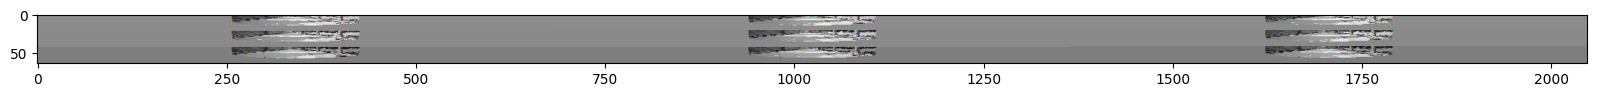

In [49]:
out= dataset.__getitem__(0)
a = out['rgb'].reshape(shape[0],shape[1],3)
# a=a.numpy().astype(np.int8)
plt.figure(figsize=(20,15))
plt.imshow(a)

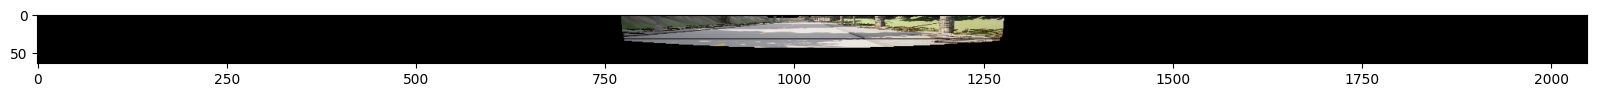

In [41]:
points_path = out['path']
rgb_path=points_path.replace("velodyne","image_2").replace("npy","png")
point_cloud = np.fromfile(points_path, dtype=np.float32).reshape((-1, 4))
rgb_image = np.array(Image.open(rgb_path))
plt.figure(figsize=(20,15))
plt.imshow(rgb_image)

In [12]:
rgb = dataset.image_to_pcl(rgb_image, point_cloud)
point_cloud = np.concatenate([point_cloud, rgb.astype('float32')], axis=1)
point_cloud.shape

(131080, 7)

In [ ]:
H=64
W=256
fov_up, fov_down = dataset.DATA.fov_up, dataset.DATA.fov_down

points, _ = point_cloud_to_xyz_image(point_cloud, H=H, W=2048, fov_down=fov_down, fov_up=fov_up,)


In [18]:
# out = {}
# out["rgb"] = point_cloud[..., -3:]/ 255.0 # h,w, c
# black_pos = (out["rgb"] == [0,0,0]).all(2)
# avg_color = np.mean(out["rgb"][~black_pos], axis=0)
# out["rgb"][black_pos] = avg_color

In [34]:
xyz = point_cloud[:, :3]  # xyz
x = xyz[:, 0]
y = xyz[:, 1]
z = xyz[:, 2]
depth = np.linalg.norm(xyz, ord=2, axis=1)
order = np.argsort(-depth)
quads = np.zeros_like(x)
quads[(x >= 0) & (y >= 0)] = 0  # 1st
quads[(x < 0) & (y >= 0)] = 1  # 2nd
quads[(x < 0) & (y < 0)] = 2  # 3rd
quads[(x >= 0) & (y < 0)] = 3  # 4th
diff = np.roll(quads, 1) - quads #Neighbour

/home/joaquinecc/miniconda3/envs/coligen2/lib/python3.8/site-packages/numpy/linalg/linalg.py:2541: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


In [35]:
(start_inds,) = np.where(diff == 3)  # number of lines
inds = list(start_inds) + [len(quads)]  # add the last index
line_idx = 63  # ...0
grid_h = np.zeros_like(x)
for i in reversed(range(len(start_inds))):
    grid_h[inds[i] : inds[i + 1]] = line_idx
    line_idx -= 1
grid_h.shape

(131080,)

In [ ]:
_map(_map(sem_label, self.DATA.learning_map), self.DATA.m_learning_map)

In [ ]:
self.rgb_list = [d.replace('velodyne', 'image_2').replace('bin' if self.is_raw else 'npy', 'png') for d in self.datalist]
